In [1]:
import geopandas as gpd
from shapely.ops import unary_union
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt


In [3]:
# 1) load and project to UTM (metric)
input_file = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\Sibelco_Stuff\DATACUBE\hotosm_fra_buildings_polygons_geojson_clipped.geojson"

gdf = gpd.read_file(input_file)
utm = gdf.estimate_utm_crs()
gdf = gdf.to_crs(utm)

In [4]:

# 2) buffer footprints to merge nearby buildings
buffer_dist = 100  # meters; adjust to cluster scale
clusters = unary_union(gdf.geometry.buffer(buffer_dist))

# 3) rasterize clusters
resolution = 10  # meters per pixel
minx, miny, maxx, maxy = clusters.bounds
width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, width, height)

mask = rasterize(
    [(clusters, 1)],
    out_shape=(height, width),
    transform=transform,
    fill=0,
    dtype="uint8",
)


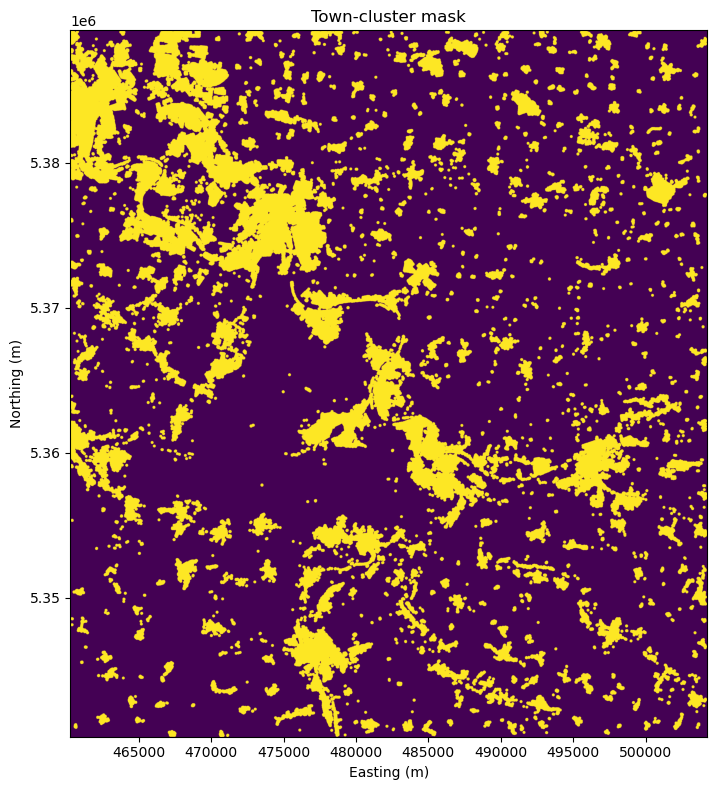

In [5]:

# 4) plot the mask
fig, ax = plt.subplots(figsize=(8, 8))
extent = (minx, maxx, miny, maxy)
ax.imshow(mask, origin="upper", extent=extent)
ax.set_title("Town‐cluster mask")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.tight_layout()
plt.show()


In [6]:
# 5) save to GeoTIFF

output_file = r"C:\Users\TyHow\MinersAI Dropbox\Tyler Howe\Sibelco_Stuff\DATACUBE\town_mask.tif"

with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=mask.dtype,
    crs=gdf.crs,
    transform=transform,
) as dst:
    dst.write(mask, 1)